**12장 – 텐서플로를 사용한 사용자 정의 모델과 훈련**

_이 노트북은 12장에 있는 모든 샘플 코드와 연습문제 해답을 가지고 있습니다._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/handson-ml2/blob/master/12_custom_models_and_training_with_tensorflow.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지와 텐서플로 버전이 2.0 이상인지 확인합니다.

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version은 코랩 명령입니다.
    %tensorflow_version 2.x
except Exception:
    pass

# 이 노트북은 텐서플로 ≥2.4이 필요합니다
# 2.x 버전은 대부분 동일한 결과를 만들지만 몇 가지 버그가 있습니다.
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.4"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 학습조직 #4(CH12.1~12.3.4)

## 텐서와 연산

### 텐서

In [2]:
tf.constant([[1., 2., 3.], [4., 5., 6.]]) # 행렬

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [3]:
tf.constant(42) # 스칼라

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [4]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
t

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [ ]:
t.shape

TensorShape([2, 3])

In [ ]:
t.dtype

tf.float32

### 인덱싱

In [ ]:
t[:, 1:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [ ]:
t[..., 1, tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

### 연산

In [ ]:
t + 10

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [ ]:
tf.square(t)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [ ]:
t @ tf.transpose(t)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

### `keras.backend` 사용하기

In [5]:
from tensorflow import keras
K = keras.backend
K.square(K.transpose(t)) + 10

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[11., 26.],
       [14., 35.],
       [19., 46.]], dtype=float32)>

### 넘파이 변환

In [6]:
a = np.array([2., 4., 5.])
tf.constant(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [7]:
t.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [8]:
np.array(t)

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [ ]:
tf.square(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [ ]:
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

### 타입 변환

In [9]:
try:
    tf.constant(2.0) + tf.constant(40)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:AddV2]


In [10]:
try:
    tf.constant(2.0) + tf.constant(40., dtype=tf.float64)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:AddV2]


In [11]:
t2 = tf.constant(40., dtype=tf.float64)
tf.constant(2.0) + tf.cast(t2, tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

### 문자열

In [12]:
tf.constant(b"hello world")

<tf.Tensor: shape=(), dtype=string, numpy=b'hello world'>

In [13]:
tf.constant("café")

<tf.Tensor: shape=(), dtype=string, numpy=b'caf\xc3\xa9'>

In [ ]:
u = tf.constant([ord(c) for c in "café"])
u

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233], dtype=int32)>

In [ ]:
b = tf.strings.unicode_encode(u, "UTF-8")
tf.strings.length(b, unit="UTF8_CHAR")

<tf.Tensor: shape=(), dtype=int32, numpy=4>

In [ ]:
tf.strings.unicode_decode(b, "UTF-8")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233], dtype=int32)>

### 문자열 배열

In [ ]:
p = tf.constant(["Café", "Coffee", "caffè", "咖啡"])

In [ ]:
tf.strings.length(p, unit="UTF8_CHAR")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([4, 6, 5, 2], dtype=int32)>

In [ ]:
r = tf.strings.unicode_decode(p, "UTF8")
r

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232], [21654, 21857]]>

In [ ]:
print(r)

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232], [21654, 21857]]>


### 래그드 텐서

In [ ]:
print(r[1])

tf.Tensor([ 67 111 102 102 101 101], shape=(6,), dtype=int32)


In [ ]:
print(r[1:3])

<tf.RaggedTensor [[67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232]]>


In [ ]:
r2 = tf.ragged.constant([[65, 66], [], [67]])
print(tf.concat([r, r2], axis=0))

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232], [21654, 21857], [65, 66], [], [67]]>


In [ ]:
r3 = tf.ragged.constant([[68, 69, 70], [71], [], [72, 73]])
print(tf.concat([r, r3], axis=1))

<tf.RaggedTensor [[67, 97, 102, 233, 68, 69, 70], [67, 111, 102, 102, 101, 101, 71], [99, 97, 102, 102, 232], [21654, 21857, 72, 73]]>


In [ ]:
tf.strings.unicode_encode(r3, "UTF-8")

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'DEF', b'G', b'', b'HI'], dtype=object)>

In [ ]:
r.to_tensor()

<tf.Tensor: shape=(4, 6), dtype=int32, numpy=
array([[   67,    97,   102,   233,     0,     0],
       [   67,   111,   102,   102,   101,   101],
       [   99,    97,   102,   102,   232,     0],
       [21654, 21857,     0,     0,     0,     0]], dtype=int32)>

### 희소 텐서

In [14]:
s = tf.SparseTensor(indices=[[0, 1], [1, 0], [2, 3]],
                    values=[1., 2., 3.],
                    dense_shape=[3, 4])

In [15]:
print(s)

SparseTensor(indices=tf.Tensor(
[[0 1]
 [1 0]
 [2 3]], shape=(3, 2), dtype=int64), values=tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [ ]:
tf.sparse.to_dense(s)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [2., 0., 0., 0.],
       [0., 0., 0., 3.]], dtype=float32)>

In [ ]:
s2 = s * 2.0

In [ ]:
try:
    s3 = s + 1.
except TypeError as ex:
    print(ex)

unsupported operand type(s) for +: 'SparseTensor' and 'float'


In [ ]:
s4 = tf.constant([[10., 20.], [30., 40.], [50., 60.], [70., 80.]])
tf.sparse.sparse_dense_matmul(s, s4)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 30.,  40.],
       [ 20.,  40.],
       [210., 240.]], dtype=float32)>

In [ ]:
s5 = tf.SparseTensor(indices=[[0, 2], [0, 1]],
                     values=[1., 2.],
                     dense_shape=[3, 4])
print(s5)

SparseTensor(indices=tf.Tensor(
[[0 2]
 [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([1. 2.], shape=(2,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [ ]:
try:
    tf.sparse.to_dense(s5)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

indices[1] = [0,1] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SparseToDense]


In [ ]:
s6 = tf.sparse.reorder(s5)
tf.sparse.to_dense(s6)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 2., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>

### 집합

In [ ]:
set1 = tf.constant([[2, 3, 5, 7], [7, 9, 0, 0]])
set2 = tf.constant([[4, 5, 6], [9, 10, 0]])
tf.sparse.to_dense(tf.sets.union(set1, set2))

<tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[ 2,  3,  4,  5,  6,  7],
       [ 0,  7,  9, 10,  0,  0]], dtype=int32)>

In [ ]:
tf.sparse.to_dense(tf.sets.difference(set1, set2))

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[2, 3, 7],
       [7, 0, 0]], dtype=int32)>

In [ ]:
tf.sparse.to_dense(tf.sets.intersection(set1, set2))

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[5, 0],
       [0, 9]], dtype=int32)>

### 변수

In [16]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])

In [ ]:
v.assign(2 * v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [17]:
v[0, 1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 1., 42.,  3.],
       [ 4.,  5.,  6.]], dtype=float32)>

In [18]:
v[:, 2].assign([0., 1.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 1., 42.,  0.],
       [ 4.,  5.,  1.]], dtype=float32)>

In [19]:
try:
    v[1] = [7., 8., 9.]
except TypeError as ex:
    print(ex)

'ResourceVariable' object does not support item assignment


In [20]:
v.scatter_nd_update(indices=[[0, 0], [1, 2]],
                    updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  4.,   5., 200.]], dtype=float32)>

In [ ]:
sparse_delta = tf.IndexedSlices(values=[[1., 2., 3.], [4., 5., 6.]],
                                indices=[1, 0])
v.scatter_update(sparse_delta)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[4., 5., 6.],
       [1., 2., 3.]], dtype=float32)>

### 텐서 배열

In [ ]:
array = tf.TensorArray(dtype=tf.float32, size=3)
array = array.write(0, tf.constant([1., 2.]))
array = array.write(1, tf.constant([3., 10.]))
array = array.write(2, tf.constant([5., 7.]))

In [ ]:
array.read(1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 3., 10.], dtype=float32)>

In [ ]:
array.stack()

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 2.],
       [0., 0.],
       [5., 7.]], dtype=float32)>

In [ ]:
mean, variance = tf.nn.moments(array.stack(), axes=0)
mean

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 3.], dtype=float32)>

In [ ]:
variance

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([4.6666665, 8.666667 ], dtype=float32)>

## 사용자 정의 손실 함수

캘리포니아 주택 데이터셋을 로드하여 준비해 보겠습니다. 먼저 이 데이터셋을 로드한 다음 훈련 세트, 검증 세트, 테스트 세트로 나눕니다. 마지막으로 스케일을 변경합니다:

In [21]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [22]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

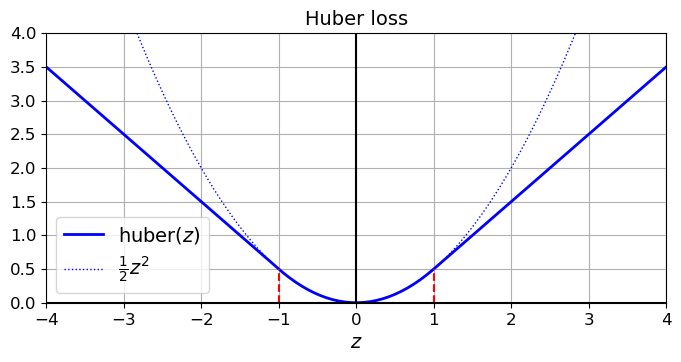

In [23]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [28]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [29]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [30]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 1.1665 - mae: 1.6007 - val_loss: 0.4160 - val_mae: 0.7648
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.3276 - mae: 0.6683 - val_loss: 0.3070 - val_mae: 0.6266


## 사용자 정의 요소를 가진 모델을 저장하고 로드하기

In [31]:
model.save("my_model_with_a_custom_loss.h5")

ImportError: `save_model` requires h5py.

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_loss.h5",
                                custom_objects={"huber_fn": huber_fn})

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 5ms/step - loss: 0.2054 - mae: 0.4982 - val_loss: 0.2209 - val_mae: 0.5050
Epoch 2/2
363/363 [==============================] - 2s 5ms/step - loss: 0.1999 - mae: 0.4900 - val_loss: 0.2127 - val_mae: 0.4986


In [ ]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [ ]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 5ms/step - loss: 0.2318 - mae: 0.4979 - val_loss: 0.2540 - val_mae: 0.4907
Epoch 2/2
363/363 [==============================] - 2s 5ms/step - loss: 0.2309 - mae: 0.4960 - val_loss: 0.2372 - val_mae: 0.4879


In [ ]:
model.save("my_model_with_a_custom_loss_threshold_2.h5")

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_loss_threshold_2.h5",
                                custom_objects={"huber_fn": create_huber(2.0)})

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 5ms/step - loss: 0.2147 - mae: 0.4800 - val_loss: 0.2133 - val_mae: 0.4654
Epoch 2/2
363/363 [==============================] - 2s 4ms/step - loss: 0.2119 - mae: 0.4762 - val_loss: 0.1992 - val_mae: 0.4643


In [ ]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [ ]:
model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 5ms/step - loss: 1.3123 - mae: 1.3345 - val_loss: 0.3378 - val_mae: 0.5485
Epoch 2/2
363/363 [==============================] - 2s 5ms/step - loss: 0.2659 - mae: 0.5270 - val_loss: 0.2660 - val_mae: 0.5089


In [ ]:
model.save("my_model_with_a_custom_loss_class.h5")

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_loss_class.h5",
                                custom_objects={"HuberLoss": HuberLoss})

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 5ms/step - loss: 0.2286 - mae: 0.4970 - val_loss: 0.2120 - val_mae: 0.4723
Epoch 2/2
363/363 [==============================] - 2s 5ms/step - loss: 0.2216 - mae: 0.4904 - val_loss: 0.2045 - val_mae: 0.4725


In [ ]:
model.loss.threshold

2.0

## 그외 사용자 정의 함수

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
def my_softplus(z): # tf.nn.softplus(z) 값을 반환합니다
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # tf.nn.relu(weights) 값을 반환합니다
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [ ]:
layer = keras.layers.Dense(1, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [ ]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 5ms/step - loss: 2.3829 - mae: 1.1635 - val_loss: 1.4154 - val_mae: 0.5607
Epoch 2/2
363/363 [==============================] - 2s 5ms/step - loss: 0.6299 - mae: 0.5410 - val_loss: 1.4399 - val_mae: 0.5137


In [ ]:
model.save("my_model_with_many_custom_parts.h5")

In [ ]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

In [ ]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor": self.factor}

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [ ]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 5ms/step - loss: 2.3829 - mae: 1.1635 - val_loss: 1.4154 - val_mae: 0.5607
Epoch 2/2
363/363 [==============================] - 2s 5ms/step - loss: 0.6299 - mae: 0.5410 - val_loss: 1.4399 - val_mae: 0.5137


In [ ]:
model.save("my_model_with_many_custom_parts.h5")

In [ ]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

## 사용자 정의 지표

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [ ]:
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 3.5903 - huber_fn: 1.5558
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.8054 - huber_fn: 0.3095


**노트**: 손실과 지표에 같은 함수를 사용하면 다른 결과가 나올 수 있습니다. 이는 일반적으로 부동 소수점 정밀도 오차 때문입니다. 수학 식이 동일하더라도 연산은 동일한 순서대로 실행되지 않습니다. 이로 인해 작은 차이가 발생합니다. 또한 샘플 가중치를 사용하면 정밀도보다 더 큰 오차가 생깁니다:

* 에포크에서 손실은 지금까지 본 모든 배치 손실의 평균입니다. 각 배치 손실은 가중치가 적용된 샘플 손실의 합을 _배치 크기_ 로 나눈 것입니다(샘플 가중치의 합으로 나눈 것이 아닙니다. 따라서 배치 손실은 손실의 가중 평균이 아닙니다).
* 에포크에서 지표는 가중치가 적용된 샘플 손실의 합을 지금까지 본 모든 샘플 가중치의 합으로 나눈 것입니다. 다른 말로하면 모든 샘플 손실의 가중 평균입니다. 따라서 위와 같지 않습니다.

수학적으로 말하면 손실 = 지표 * 샘플 가중치의 평균(더하기 약간의 부동 소수점 정밀도 오차)입니다.

In [ ]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[create_huber(2.0)])

In [ ]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 0.1245 - huber_fn: 0.2515
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.1216 - huber_fn: 0.2473


In [ ]:
history.history["loss"][0], history.history["huber_fn"][0] * sample_weight.mean()

(0.11749906837940216, 0.11906624094207695)

### 스트리밍 지표

In [ ]:
precision = keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [ ]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [ ]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [ ]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [ ]:
precision.reset_states()

스트리밍 지표 만들기:

In [ ]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # 기본 매개변수 처리 (예를 들면, dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    def result(self):
        return self.total / self.count
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [ ]:
m = HuberMetric(2.)

# total = 2 * |10 - 2| - 2²/2 = 14
# count = 1
# result = 14 / 1 = 14
m(tf.constant([[2.]]), tf.constant([[10.]])) 

<tf.Tensor: shape=(), dtype=float32, numpy=14.0>

In [ ]:
# total = total + (|1 - 0|² / 2) + (2 * |9.25 - 5| - 2² / 2) = 14 + 7 = 21
# count = count + 2 = 3
# result = total / count = 21 / 3 = 7
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [ ]:
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=21.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=3.0>]

In [ ]:
m.reset_states()
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=0.0>]

`HuberMetric` 클래스가 잘 동작하는지 확인해 보죠:

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [ ]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[HuberMetric(2.0)])

In [ ]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 1.5182 - huber_metric: 1.5182
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.2909 - huber_metric: 0.2909


In [ ]:
model.save("my_model_with_a_custom_metric.h5")

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_metric.h5",
                                custom_objects={"huber_fn": create_huber(2.0),
                                                "HuberMetric": HuberMetric})

In [ ]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 0.2350 - huber_metric: 0.2350
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.2278 - huber_metric: 0.2278


**경고**: 텐서플로 2.2에서 tf.keras가 `model.metrics`의 0번째 위치에 지표를 추가합니다([텐서플로 이슈 #38150](https://github.com/tensorflow/tensorflow/issues/38150) 참조). 따라서 `HuberMetric`에 접근하려면 `model.metrics[0]` 대신 `model.metrics[-1]`를 사용해야 합니다.

In [ ]:
model.metrics[-1].threshold

2.0

잘 동작하는군요! 다음처럼 더 간단하게 클래스를 만들 수 있습니다:

In [ ]:
class HuberMetric(keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}        

이 클래스는 크기를 잘 처리하고 샘플 가중치도 지원합니다.

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [ ]:
model.compile(loss=keras.losses.Huber(2.0), optimizer="nadam", weighted_metrics=[HuberMetric(2.0)])

In [ ]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32),
                    epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 0.7800 - HuberMetric: 1.5672
Epoch 2/2
363/363 [==============================] - 2s 5ms/step - loss: 0.1462 - HuberMetric: 0.2939


In [ ]:
history.history["loss"][0], history.history["HuberMetric"][0] * sample_weight.mean()

(0.44554364681243896, 0.44554368685750223)

In [ ]:
model.save("my_model_with_a_custom_metric_v2.h5")

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_metric_v2.h5",
                                custom_objects={"HuberMetric": HuberMetric})

In [ ]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 0.2377 - HuberMetric: 0.2377
Epoch 2/2
363/363 [==============================] - 2s 4ms/step - loss: 0.2279 - HuberMetric: 0.2279


In [ ]:
model.metrics[-1].threshold

2.0

# 4번째  학습조직 범위 여기까지

## 사용자 정의 층

In [ ]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

In [ ]:
exponential_layer([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787948, 1.        , 2.7182817 ], dtype=float32)>

회귀 모델이 예측할 값이 양수이고 스케일이 매우 다른 경우 (예를 들어, 0.001, 10., 10000) 출력층에 지수 함수를 추가하면 유용할 수 있습니다:

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1),
    exponential_layer
])
model.compile(loss="mse", optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/5
363/363 [==============================] - 1s 3ms/step - loss: 2.1275 - val_loss: 0.4457
Epoch 2/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4750 - val_loss: 0.3798
Epoch 3/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4230 - val_loss: 0.3548
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.3905 - val_loss: 0.3464
Epoch 5/5
162/162 [==============================] - 0s 2ms/step - loss: 0.3586


0.3586341142654419

In [ ]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": keras.activations.serialize(self.activation)}

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])

In [ ]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 4.1268 - val_loss: 0.9472
Epoch 2/2
162/162 [==============================] - 0s 2ms/step - loss: 0.5474


0.5473727583885193

In [ ]:
model.save("my_model_with_a_custom_layer.h5")

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_layer.h5",
                                custom_objects={"MyDense": MyDense})

In [ ]:
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        return X1 + X2, X1 * X2

    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape2]

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
inputs1 = keras.layers.Input(shape=[2])
inputs2 = keras.layers.Input(shape=[2])
outputs1, outputs2 = MyMultiLayer()((inputs1, inputs2))

훈련과 테스트에서 다르게 동작하는 층을 만들어 보죠:

In [ ]:
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

In [ ]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 0.5496 - val_loss: 0.5329
Epoch 2/2
162/162 [==============================] - 0s 2ms/step - loss: 0.3990


0.39900389313697815

## 사용자 정의 모델

In [ ]:
X_new_scaled = X_test_scaled

In [ ]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu",
                                          kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

In [ ]:
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 4s 7ms/step - loss: 22.7477
Epoch 2/5
363/363 [==============================] - 3s 8ms/step - loss: 1.2735
Epoch 3/5
363/363 [==============================] - 3s 7ms/step - loss: 0.9792
Epoch 4/5
363/363 [==============================] - 3s 8ms/step - loss: 0.5905
Epoch 5/5
162/162 [==============================] - 1s 2ms/step - loss: 0.6514


In [ ]:
model.save("my_custom_model.ckpt")

INFO:tensorflow:Assets written to: my_custom_model.ckpt/assets


INFO:tensorflow:Assets written to: my_custom_model.ckpt/assets


In [ ]:
model = keras.models.load_model("my_custom_model.ckpt")

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 [==============================] - 4s 7ms/step - loss: 0.9441
Epoch 2/5
363/363 [==============================] - 3s 7ms/step - loss: 0.6795
Epoch 3/5
363/363 [==============================] - 3s 7ms/step - loss: 0.4323
Epoch 4/5
363/363 [==============================] - 3s 7ms/step - loss: 0.5340
Epoch 5/5
363/363 [==============================] - 3s 7ms/step - loss: 0.4360


대신 시퀀셜 API를 사용하는 모델을 정의할 수 있습니다:

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
block1 = ResidualBlock(2, 30)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    keras.layers.Dense(1)
])

In [ ]:
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 3s 6ms/step - loss: 1.5508
Epoch 2/5
363/363 [==============================] - 2s 7ms/step - loss: 0.5562
Epoch 3/5
363/363 [==============================] - 2s 6ms/step - loss: 0.6406
Epoch 4/5
363/363 [==============================] - 2s 6ms/step - loss: 0.3759
Epoch 5/5
162/162 [==============================] - 0s 2ms/step - loss: 0.4852


## 모델 구성 요소에 기반한 손실과 지표

**노트**: TF 2.2에 있는 이슈([#46858](https://github.com/tensorflow/tensorflow/issues/46858)) 때문에 `build()` 메서드와 함께 `add_loss()`를 사용할 수 없습니다. 따라서 다음 코드는 책과 다릅니다. `build()` 메서드 대신 생성자에 `reconstruct` 층을 만듭니다. 이 때문에 이 층의 유닛 개수를 하드코딩해야 합니다(또는 생성자 매개변수로 전달해야 합니다).

In [ ]:
class ReconstructingRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        self.reconstruct = keras.layers.Dense(8) # TF 이슈 #46858에 대한 대책
        self.reconstruction_mean = keras.metrics.Mean(name="reconstruction_error")

#     TF 이슈 #46858 때문에 주석 처리
#     def build(self, batch_input_shape):
#         n_inputs = batch_input_shape[-1]
#         self.reconstruct = keras.layers.Dense(n_inputs, name='recon')
#         super().build(batch_input_shape)

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        self.recon_loss = 0.05 * tf.reduce_mean(tf.square(reconstruction - inputs))
        
        if training:
           result = self.reconstruction_mean(recon_loss)
           self.add_metric(result)
        return self.out(Z)
    
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred, regularization_losses=[self.recon_loss])

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return {m.name: m.result() for m in self.metrics}

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)
y_pred = model.predict(X_test_scaled)

Epoch 1/2
363/363 [==============================] - 4s 7ms/step - loss: 1.6313 - reconstruction_error: 0.0000e+00
Epoch 2/2
363/363 [==============================] - 3s 7ms/step - loss: 0.4543 - reconstruction_error: 0.0000e+00


## 자동 미분을 사용하여 그레이디언트 계산하기

In [ ]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

In [ ]:
w1, w2 = 5, 3
eps = 1e-6
(f(w1 + eps, w2) - f(w1, w2)) / eps

36.000003007075065

In [ ]:
(f(w1, w2 + eps) - f(w1, w2)) / eps

10.000000003174137

In [ ]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2])

In [ ]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [ ]:
with tf.GradientTape() as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
try:
    dz_dw2 = tape.gradient(z, w2)
except RuntimeError as ex:
    print(ex)

A non-persistent GradientTape can only be used tocompute one set of gradients (or jacobians)


In [ ]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
dz_dw2 = tape.gradient(z, w2) # works now!
del tape

In [ ]:
dz_dw1, dz_dw2

(<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>)

In [ ]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [ ]:
gradients

[None, None]

In [ ]:
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [ ]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [ ]:
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tape.gradient([z1, z2, z3], [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [ ]:
with tf.GradientTape(persistent=True) as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tf.reduce_sum(tf.stack([tape.gradient(z, [w1, w2]) for z in (z1, z2, z3)]), axis=0)
del tape

In [ ]:
with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z = f(w1, w2)
    jacobians = jacobian_tape.gradient(z, [w1, w2])
hessians = [hessian_tape.gradient(jacobian, [w1, w2])
            for jacobian in jacobians]
del hessian_tape

In [ ]:
jacobians

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [ ]:
hessians

[[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.0>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=2.0>, None]]

In [ ]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)

tape.gradient(z, [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

In [ ]:
x = tf.Variable(100.)
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(), dtype=float32, numpy=nan>]

In [ ]:
tf.math.log(tf.exp(tf.constant(30., dtype=tf.float32)) + 1.)

<tf.Tensor: shape=(), dtype=float32, numpy=30.0>

In [ ]:
x = tf.Variable([100.])
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>]

In [ ]:
@tf.custom_gradient
def my_better_softplus(z):
    exp = tf.exp(z)
    def my_softplus_gradients(grad):
        return grad / (1 + 1 / exp)
    return tf.math.log(exp + 1), my_softplus_gradients

In [ ]:
def my_better_softplus(z):
    return tf.where(z > 30., z, tf.math.log(tf.exp(z) + 1.))

In [ ]:
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_better_softplus(x)

z, tape.gradient(z, [x])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1000.], dtype=float32)>,
 [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>])

# 사용자 정의 훈련 반복

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
l2_reg = keras.regularizers.l2(0.05)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=l2_reg),
    keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

In [ ]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [ ]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics,
          end=end)

In [ ]:
import time

mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 - loss: 0.0900 - mean_square: 858.5000


A fancier version with a progress bar:

In [ ]:
def progress_bar(iteration, total, size=30):
    running = iteration < total
    c = ">" if running else "="
    p = (size - 1) * iteration // total
    fmt = "{{:-{}d}}/{{}} [{{}}]".format(len(str(total)))
    params = [iteration, total, "=" * p + c + "." * (size - p - 1)]
    return fmt.format(*params)

In [ ]:
progress_bar(3500, 10000, size=6)

' 3500/10000 [=>....]'

In [ ]:
def print_status_bar(iteration, total, loss, metrics=None, size=30):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{} - {}".format(progress_bar(iteration, total), metrics), end=end)

In [ ]:
mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 [==============================] - loss: 0.0900 - mean_square: 858.5000


In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]

In [ ]:
for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5
11610/11610 [==============================] - mean: 1.3955 - mean_absolute_error: 0.5722
Epoch 2/5
11610/11610 [==============================] - mean: 0.6774 - mean_absolute_error: 0.5280
Epoch 3/5
11610/11610 [==============================] - mean: 0.6351 - mean_absolute_error: 0.5177
Epoch 4/5
11610/11610 [==============================] - mean: 0.6384 - mean_absolute_error: 0.5181
Epoch 5/5
11610/11610 [==============================] - mean: 0.6440 - mean_absolute_error: 0.5222


In [ ]:
try:
    from tqdm.notebook import trange
    from collections import OrderedDict
    with trange(1, n_epochs + 1, desc="All epochs") as epochs:
        for epoch in epochs:
            with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
                for step in steps:
                    X_batch, y_batch = random_batch(X_train_scaled, y_train)
                    with tf.GradientTape() as tape:
                        y_pred = model(X_batch)
                        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                        loss = tf.add_n([main_loss] + model.losses)
                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                    for variable in model.variables:
                        if variable.constraint is not None:
                            variable.assign(variable.constraint(variable))                    
                    status = OrderedDict()
                    mean_loss(loss)
                    status["loss"] = mean_loss.result().numpy()
                    for metric in metrics:
                        metric(y_batch, y_pred)
                        status[metric.name] = metric.result().numpy()
                    steps.set_postfix(status)
            for metric in [mean_loss] + metrics:
                metric.reset_states()
except ImportError as ex:
    print("To run this cell, please install tqdm, ipywidgets and restart Jupyter")

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/362 [00:00<?, ?it/s]

## 텐서플로 함수

In [ ]:
def cube(x):
    return x ** 3

In [ ]:
cube(2)

8

In [ ]:
cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [ ]:
tf_cube = tf.function(cube)
tf_cube

In [ ]:
tf_cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [ ]:
tf_cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

### TF 함수와 콘크리트 함수

In [ ]:
concrete_function = tf_cube.get_concrete_function(tf.constant(2.0))
concrete_function.graph

In [ ]:
concrete_function(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [ ]:
concrete_function is tf_cube.get_concrete_function(tf.constant(2.0))

True

### 함수 정의와 그래프

In [ ]:
concrete_function.graph

In [ ]:
ops = concrete_function.graph.get_operations()
ops

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'pow/y' type=Const>,
 <tf.Operation 'pow' type=Pow>,
 <tf.Operation 'Identity' type=Identity>]

In [ ]:
pow_op = ops[2]
list(pow_op.inputs)

[<tf.Tensor 'x:0' shape=() dtype=float32>,
 <tf.Tensor 'pow/y:0' shape=() dtype=float32>]

In [ ]:
pow_op.outputs

[<tf.Tensor 'pow:0' shape=() dtype=float32>]

In [ ]:
concrete_function.graph.get_operation_by_name('x')

<tf.Operation 'x' type=Placeholder>

In [ ]:
concrete_function.graph.get_tensor_by_name('Identity:0')

<tf.Tensor 'Identity:0' shape=() dtype=float32>

In [ ]:
concrete_function.function_def.signature

name: "__inference_cube_1063719"
input_arg {
  name: "x"
  type: DT_FLOAT
}
output_arg {
  name: "identity"
  type: DT_FLOAT
}

### TF 함수가 계산 그래프를 추출하기 위해 파이썬 함수를 트레이싱하는 방법

In [ ]:
@tf.function
def tf_cube(x):
    print("print:", x)
    return x ** 3

In [ ]:
result = tf_cube(tf.constant(2.0))

print: Tensor("x:0", shape=(), dtype=float32)


In [ ]:
result

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [ ]:
result = tf_cube(2)
result = tf_cube(3)
result = tf_cube(tf.constant([[1., 2.]])) # New shape: trace!
result = tf_cube(tf.constant([[3., 4.], [5., 6.]])) # New shape: trace!
result = tf_cube(tf.constant([[7., 8.], [9., 10.], [11., 12.]])) # New shape: trace!

print: 2
print: 3
print: Tensor("x:0", shape=(1, 2), dtype=float32)
print: Tensor("x:0", shape=(2, 2), dtype=float32)


print: Tensor("x:0", shape=(3, 2), dtype=float32)


특정 입력 시그니처를 지정하는 것도 가능합니다:

In [ ]:
@tf.function(input_signature=[tf.TensorSpec([None, 28, 28], tf.float32)])
def shrink(images):
    print("트레이싱", images)
    return images[:, ::2, ::2] # 행과 열의 절반을 버립니다

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
img_batch_1 = tf.random.uniform(shape=[100, 28, 28])
img_batch_2 = tf.random.uniform(shape=[50, 28, 28])
preprocessed_images = shrink(img_batch_1) # 함수 트레이싱
preprocessed_images = shrink(img_batch_2) # 동일한 콘크리트 함수 재사용

트레이싱 Tensor("images:0", shape=(None, 28, 28), dtype=float32)


In [ ]:
img_batch_3 = tf.random.uniform(shape=[2, 2, 2])
try:
    preprocessed_images = shrink(img_batch_3)  # 다른 타입이나 크기 거부
except ValueError as ex:
    print(ex)

Python inputs incompatible with input_signature:
  inputs: (
    tf.Tensor(
[[[0.7413678  0.62854624]
  [0.01738465 0.3431449 ]]

 [[0.51063764 0.3777541 ]
  [0.07321596 0.02137029]]], shape=(2, 2, 2), dtype=float32))
  input_signature: (
    TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None))


### 오토그래프를 사용해 제어 흐름 나타내기

`range()`를  사용한 정적인 `for` 반복:

In [ ]:
@tf.function
def add_10(x):
    for i in range(10):
        x += 1
    return x

In [ ]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [ ]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'add/y' type=Const>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'add_1/y' type=Const>,
 <tf.Operation 'add_1' type=AddV2>,
 <tf.Operation 'add_2/y' type=Const>,
 <tf.Operation 'add_2' type=AddV2>,
 <tf.Operation 'add_3/y' type=Const>,
 <tf.Operation 'add_3' type=AddV2>,
 <tf.Operation 'add_4/y' type=Const>,
 <tf.Operation 'add_4' type=AddV2>,
 <tf.Operation 'add_5/y' type=Const>,
 <tf.Operation 'add_5' type=AddV2>,
 <tf.Operation 'add_6/y' type=Const>,
 <tf.Operation 'add_6' type=AddV2>,
 <tf.Operation 'add_7/y' type=Const>,
 <tf.Operation 'add_7' type=AddV2>,
 <tf.Operation 'add_8/y' type=Const>,
 <tf.Operation 'add_8' type=AddV2>,
 <tf.Operation 'add_9/y' type=Const>,
 <tf.Operation 'add_9' type=AddV2>,
 <tf.Operation 'Identity' type=Identity>]

`tf.while_loop()`를 사용한 동적인 반복:

In [ ]:
@tf.function
def add_10(x):
    condition = lambda i, x: tf.less(i, 10)
    body = lambda i, x: (tf.add(i, 1), tf.add(x, 1))
    final_i, final_x = tf.while_loop(condition, body, [tf.constant(0), x])
    return final_x

In [ ]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [ ]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'Const' type=Const>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

(오토그래프에 의한) `tf.range()`를 사용한 동적인 `for` 반복:

In [ ]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x = x + 1
    return x

In [ ]:
add_10.get_concrete_function(tf.constant(0)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'range/start' type=Const>,
 <tf.Operation 'range/limit' type=Const>,
 <tf.Operation 'range/delta' type=Const>,
 <tf.Operation 'range' type=Range>,
 <tf.Operation 'sub' type=Sub>,
 <tf.Operation 'floordiv' type=FloorDiv>,
 <tf.Operation 'mod' type=FloorMod>,
 <tf.Operation 'zeros_like' type=Const>,
 <tf.Operation 'NotEqual' type=NotEqual>,
 <tf.Operation 'Cast' type=Cast>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'zeros_like_1' type=Const>,
 <tf.Operation 'Maximum' type=Maximum>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

### TF 함수에서 변수와 다른 자원 다루기

In [ ]:
counter = tf.Variable(0)

@tf.function
def increment(counter, c=1):
    return counter.assign_add(c)

In [ ]:
increment(counter)
increment(counter)

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [ ]:
function_def = increment.get_concrete_function(counter).function_def
function_def.signature.input_arg[0]

name: "counter"
type: DT_RESOURCE

In [ ]:
counter = tf.Variable(0)

@tf.function
def increment(c=1):
    return counter.assign_add(c)

In [ ]:
increment()
increment()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [ ]:
function_def = increment.get_concrete_function().function_def
function_def.signature.input_arg[0]

name: "assignaddvariableop_resource"
type: DT_RESOURCE

In [ ]:
class Counter:
    def __init__(self):
        self.counter = tf.Variable(0)

    @tf.function
    def increment(self, c=1):
        return self.counter.assign_add(c)

In [ ]:
c = Counter()
c.increment()
c.increment()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [ ]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x += 1
    return x

print(tf.autograph.to_code(add_10.python_function))

def tf__add(x):
    with ag__.FunctionScope('add_10', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            (x,) = vars_

        def loop_body(itr):
            nonlocal x
            i = itr
            x = ag__.ld(x)
            x += 1
        i = ag__.Undefined('i')
        ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (10,), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'i'})
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)



In [ ]:
def display_tf_code(func):
    from IPython.display import display, Markdown
    if hasattr(func, "python_function"):
        func = func.python_function
    code = tf.autograph.to_code(func)
    display(Markdown('```python\n{}\n```'.format(code)))

In [ ]:
display_tf_code(add_10)

```python
def tf__add(x):
    with ag__.FunctionScope('add_10', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            (x,) = vars_

        def loop_body(itr):
            nonlocal x
            i = itr
            x = ag__.ld(x)
            x += 1
        i = ag__.Undefined('i')
        ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (10,), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'i'})
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)

```

## tf.keras와 TF 함수를 함께 사용하거나 사용하지 않기

기본적으로 tf.keras는 자동으로 사용자 정의 코드를 TF 함수로 변환하기 때문에 `tf.function()`을 사용할 필요가 없습니다:

In [ ]:
# 사용자 손실 함수
def my_mse(y_true, y_pred):
    print("my_mse() 손실 트레이싱")
    return tf.reduce_mean(tf.square(y_pred - y_true))

In [ ]:
# 사용자 지표 함수
def my_mae(y_true, y_pred):
    print("my_mae() 지표 트레이싱")
    return tf.reduce_mean(tf.abs(y_pred - y_true))

In [ ]:
# 사용자 정의 층
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.units),
                                      initializer='uniform',
                                      trainable=True)
        self.biases = self.add_weight(name='bias', 
                                      shape=(self.units,),
                                      initializer='zeros',
                                      trainable=True)
        super().build(input_shape)

    def call(self, X):
        print("MyDense.call() 트레이싱")
        return self.activation(X @ self.kernel + self.biases)

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# 사용자 정의 모델
class MyModel(keras.models.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = MyDense(30, activation="relu")
        self.hidden2 = MyDense(30, activation="relu")
        self.output_ = MyDense(1)

    def call(self, input):
        print("MyModel.call() 트레이싱")
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()

In [ ]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
360/363 [============================>.] - ETA: 0s - loss: 2.7916 - my_mae: 1.2506MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
363/363 [==============================] - 3s 6ms/step - loss: 2.7755 - my_mae: 1.2455 - val_loss: 0.5569 - val_my_mae: 0.4819
Epoch 2/2
162/162 [==============================] - 0s 2ms/step - loss: 0.4164 - my_mae: 0.4639


[0.41635245084762573, 0.4639028012752533]

`dynamic=True`로 모델을 만들어 이 기능을 끌 수 있습니다(또는 모델의 생성자에서 `super().__init__(dynamic=True, **kwargs)`를 호출합니다):

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = MyModel(dynamic=True)

In [ ]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

사용자 정의 코드는 반복마다 호출됩니다. 너무 많이 출력되는 것을 피하기 위해 작은 데이터셋으로 훈련, 검증, 평가해 보겠습니다:

In [ ]:
model.fit(X_train_scaled[:64], y_train[:64], epochs=1,
          validation_data=(X_valid_scaled[:64], y_valid[:64]), verbose=0)
model.evaluate(X_test_scaled[:64], y_test[:64], verbose=0)

MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱


[5.507259368896484, 2.0566811561584473]

또는 모델을 컴파일할 때 `run_eagerly=True`를 지정합니다:

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = MyModel()

In [ ]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae], run_eagerly=True)

In [ ]:
model.fit(X_train_scaled[:64], y_train[:64], epochs=1,
          validation_data=(X_valid_scaled[:64], y_valid[:64]), verbose=0)
model.evaluate(X_test_scaled[:64], y_test[:64], verbose=0)

MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱


[5.507259368896484, 2.0566811561584473]

## 사용자 정의 옵티마이저

사용자 정의 옵티마이저를 정의하는 것은 일반적이지 않습니다. 하지만 어쩔 수 없이 만들어야 하는 상황이라면 다음 예를 참고하세요:

In [ ]:
class MyMomentumOptimizer(keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.001, momentum=0.9, name="MyMomentumOptimizer", **kwargs):
        """super().__init__()를 호출하고 _set_hyper()를 사용해 하이퍼파라미터를 저장합니다"""
        super().__init__(name, **kwargs)
        self._set_hyper("learning_rate", kwargs.get("lr", learning_rate)) # lr=learning_rate을 처리
        self._set_hyper("decay", self._initial_decay) # 
        self._set_hyper("momentum", momentum)
    
    def _create_slots(self, var_list):
        """모델 파라미터마다 연관된 옵티마이저 변수를 만듭니다.
        텐서플로는 이런 옵티마이저 변수를 '슬롯'이라고 부릅니다.
        모멘텀 옵티마이저에서는 모델 파라미터마다 하나의 모멘텀 슬롯이 필요합니다.
        """
        for var in var_list:
            self.add_slot(var, "momentum")

    @tf.function
    def _resource_apply_dense(self, grad, var):
        """슬롯을 업데이트하고 모델 파라미터에 대한 옵티마이저 스텝을 수행합니다.
        """
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype) # 학습률 감쇠 처리
        momentum_var = self.get_slot(var, "momentum")
        momentum_hyper = self._get_hyper("momentum", var_dtype)
        momentum_var.assign(momentum_var * momentum_hyper - (1. - momentum_hyper)* grad)
        var.assign_add(momentum_var * lr_t)

    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "learning_rate": self._serialize_hyperparameter("learning_rate"),
            "decay": self._serialize_hyperparameter("decay"),
            "momentum": self._serialize_hyperparameter("momentum"),
        }

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([keras.layers.Dense(1, input_shape=[8])])
model.compile(loss="mse", optimizer=MyMomentumOptimizer())
model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 [==============================] - 1s 2ms/step - loss: 4.9648
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 1.7888
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 1.0021
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.7869
Epoch 5/5
363/363 [==============================] - 1s 2ms/step - loss: 0.7122


# 연습문제

## 1. to 11.
부록 A 참조.

# 12. _층 정규화_ 를 수행하는 사용자 정의 층을 구현하세요.

_15장에서 순환 신경망을 사용할 때 이런 종류의 층을 사용합니다._

### a.
_문제: `build()` 메서드에서 두 개의 훈련 가능한 가중치 *α*와 *β*를 정의합니다. 두 가중치 모두 크기가 `input_shape[-1:]`이고 데이터 타입은 `tf.float32`입니다. *α*는 1로 초기화되고 *β*는 0으로 초기화되어야 합니다._

솔루션: 아래 참조.

### b.
_문제: `call()` 메서드는 샘플의 특성마다 평균 μ와 표준편차 σ를 계산해야 합니다. 이를 위해 전체 샘플의 평균 μ와 분산 σ<sup>2</sup>을 반환하는 `tf.nn.moments(inputs, axes=-1, keepdims=True)`을 사용할 수 있습니다(분산의 제곱근으로 표준편차를 계산합니다). 그다음 *α*⊗(*X* - μ)/(σ + ε) + *β*를 계산하여 반환합니다. 여기에서 ⊗는 원소별
곱셈(`*`)을 나타냅니다. ε은 안전을 위한 항입니다(0으로 나누어지는 것을 막기 위한 작은 상수. 예를 들면 0.001)._

In [ ]:
class LayerNormalization(keras.layers.Layer):
    def __init__(self, eps=0.001, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps

    def build(self, batch_input_shape):
        self.alpha = self.add_weight(
            name="alpha", shape=batch_input_shape[-1:],
            initializer="ones")
        self.beta = self.add_weight(
            name="beta", shape=batch_input_shape[-1:],
            initializer="zeros")
        super().build(batch_input_shape) # 반드시 끝에 와야 합니다

    def call(self, X):
        mean, variance = tf.nn.moments(X, axes=-1, keepdims=True)
        return self.alpha * (X - mean) / (tf.sqrt(variance + self.eps)) + self.beta

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "eps": self.eps}

_ε_ 하이퍼파라미터(`eps`)는 필수가 아닙니다. 또한 `tf.sqrt(variance) + self.eps` 보다 `tf.sqrt(variance + self.eps)`를 계산하는 것이 좋습니다. sqrt(z)의 도함수는 z=0에서 정의되지 않기 때문에 분산 벡터의 한 원소가 0에 가까우면 훈련이 이리저리 널뜁니다. 제곱근 안에 _ε_를 넣으면 이런 현상을 방지할 수 있습니다.

### c.
_문제: 사용자 정의 층이 `keras.layers.LayerNormalization` 층과 동일한(또는 거의 동일한) 출력을 만드는지 확인하세요._

각 클래스의 객체를 만들고 데이터(예를 들면, 훈련 세트)를 적용해 보죠. 차이는 무시할 수 있는 수준입니다.

In [ ]:
X = X_train.astype(np.float32)

custom_layer_norm = LayerNormalization()
keras_layer_norm = keras.layers.LayerNormalization()

tf.reduce_mean(keras.losses.mean_absolute_error(
    keras_layer_norm(X), custom_layer_norm(X)))

<tf.Tensor: shape=(), dtype=float32, numpy=3.80914e-08>

네 충분히 가깝네요. 조금 더 확실하게 알파와 베타를 완전히 랜덤하게 지정하고 다시 비교해 보죠:

In [ ]:
random_alpha = np.random.rand(X.shape[-1])
random_beta = np.random.rand(X.shape[-1])

custom_layer_norm.set_weights([random_alpha, random_beta])
keras_layer_norm.set_weights([random_alpha, random_beta])

tf.reduce_mean(keras.losses.mean_absolute_error(
    keras_layer_norm(X), custom_layer_norm(X)))

<tf.Tensor: shape=(), dtype=float32, numpy=1.695759e-08>

여전히 무시할 수 있는 수준입니다! 사용자 정의 층이 잘 동작합니다.

## 13. 사용자 정의 훈련 반복을 사용해 패션 MNIST 데이터셋으로 모델을 훈련해보세요.

_패션 MNIST 데이터셋은 10장에서 소개했습니다._

### a.
_문제: 에포크, 반복, 평균 훈련 손실, (반복마다 업데이트되는) 에포크의 평균 정확도는 물론 에포크 끝에서 검증 손실과 정확도를 출력하세요._

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test.astype(np.float32) / 255.

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])

In [ ]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.sparse_categorical_crossentropy
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.SparseCategoricalAccuracy()]

In [ ]:
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape() as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))                    
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()


All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/1718 [00:00<?, ?it/s]

### b.
_문제: 상위 층과 하위 층에 학습률이 다른 옵티마이저를 따로 사용해보세요._

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
lower_layers = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
])
upper_layers = keras.models.Sequential([
    keras.layers.Dense(10, activation="softmax"),
])
model = keras.models.Sequential([
    lower_layers, upper_layers
])

In [ ]:
lower_optimizer = keras.optimizers.SGD(lr=1e-4)
upper_optimizer = keras.optimizers.Nadam(lr=1e-3)

In [ ]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
loss_fn = keras.losses.sparse_categorical_crossentropy
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.SparseCategoricalAccuracy()]

In [ ]:
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape(persistent=True) as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                for layers, optimizer in ((lower_layers, lower_optimizer),
                                          (upper_layers, upper_optimizer)):
                    gradients = tape.gradient(loss, layers.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, layers.trainable_variables))
                del tape
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))                    
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/1718 [00:00<?, ?it/s]